# **House Prices Advanced Regression Project Team 1**

In [48]:
try:
    import shap
    import numpy as np 
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "numpy"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pandas"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "seaborn"])
    
    import shap
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns





In [49]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [50]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# **A) Data Loading and Inspection**

In [51]:
try:
    train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
    test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
except FileNotFoundError:
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')

In [52]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (1460, 81)
Test shape: (1459, 80)


In [53]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [54]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [55]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [56]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [57]:

summary = pd.DataFrame({
    "Dataset": ["Train", "Test"],
    "Rows": [train_df.shape[0], test_df.shape[0]],
    "Columns": [train_df.shape[1], test_df.shape[1]],
    "Missing Values": [train_df.isnull().sum().sum(), test_df.isnull().sum().sum()]
})

display(summary)

,Dataset,Rows,Columns,Missing Values
0,Train,1460,81,7829
1,Test,1459,80,7878


In [58]:
print("Duplicated records in train set:", train_df.duplicated().sum())
print("Duplicated records in test set:", test_df.duplicated().sum())

Duplicated records in train set: 0
Duplicated records in test set: 0


# **B) EDA (Exploratory Data Analysis)**

**1. Target Analysis (SalePrice)**

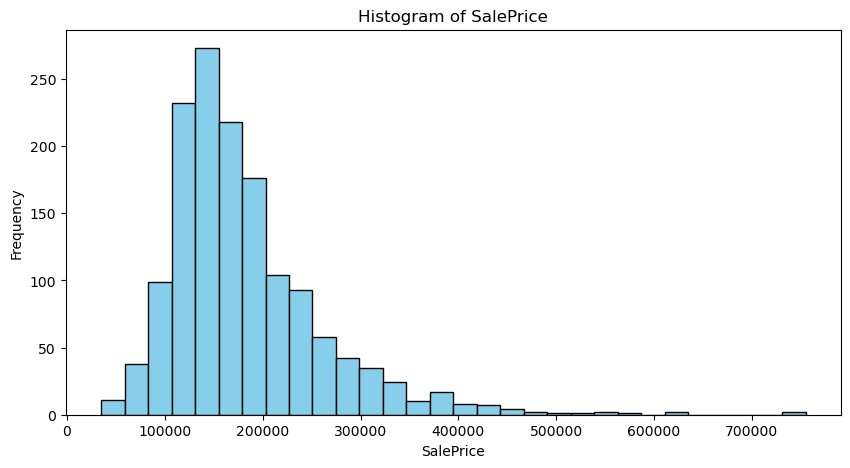

In [59]:
# a. Histogram of SalePrice
plt.figure(figsize=(10,5))
plt.hist(train_df['SalePrice'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

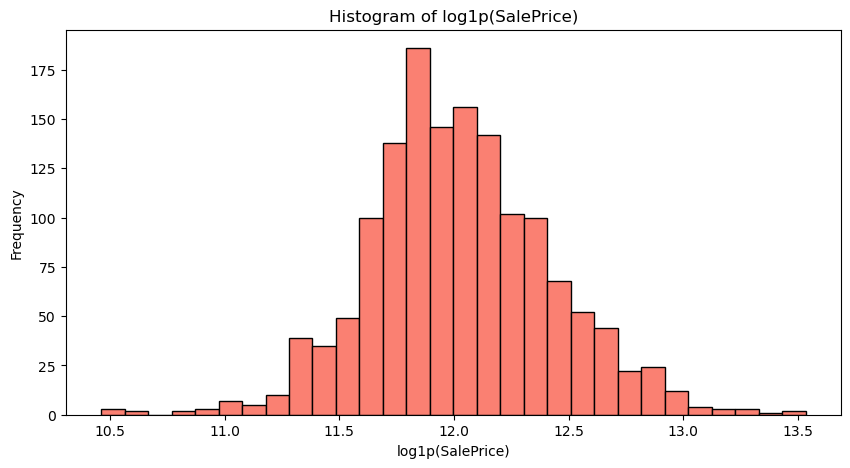

In [60]:
# b. Histogram of log1p(SalePrice)
plt.figure(figsize=(10,5))
plt.hist(np.log1p(train_df['SalePrice']), bins=30, color='salmon', edgecolor='black')
plt.title('Histogram of log1p(SalePrice)')
plt.xlabel('log1p(SalePrice)')
plt.ylabel('Frequency')
plt.show()

In [61]:
# c. Skewness Check
print("SalePrice Skewness:", train_df['SalePrice'].skew())
print("log1p(SalePrice) Skewness:", np.log1p(train_df['SalePrice']).skew())

SalePrice Skewness: 1.8828757597682129
log1p(SalePrice) Skewness: 0.12134661989685333


**2. Missing Value Analysis**

              MissingCount  MissingPercent
PoolQC                1453       99.520548
MiscFeature           1406       96.301370
Alley                 1369       93.767123
Fence                 1179       80.753425
MasVnrType             872       59.726027
FireplaceQu            690       47.260274
LotFrontage            259       17.739726
GarageType              81        5.547945
GarageYrBlt             81        5.547945
GarageFinish            81        5.547945
GarageQual              81        5.547945
GarageCond              81        5.547945
BsmtFinType2            38        2.602740
BsmtExposure            38        2.602740
BsmtFinType1            37        2.534247
BsmtCond                37        2.534247
BsmtQual                37        2.534247
MasVnrArea               8        0.547945
Electrical               1        0.068493


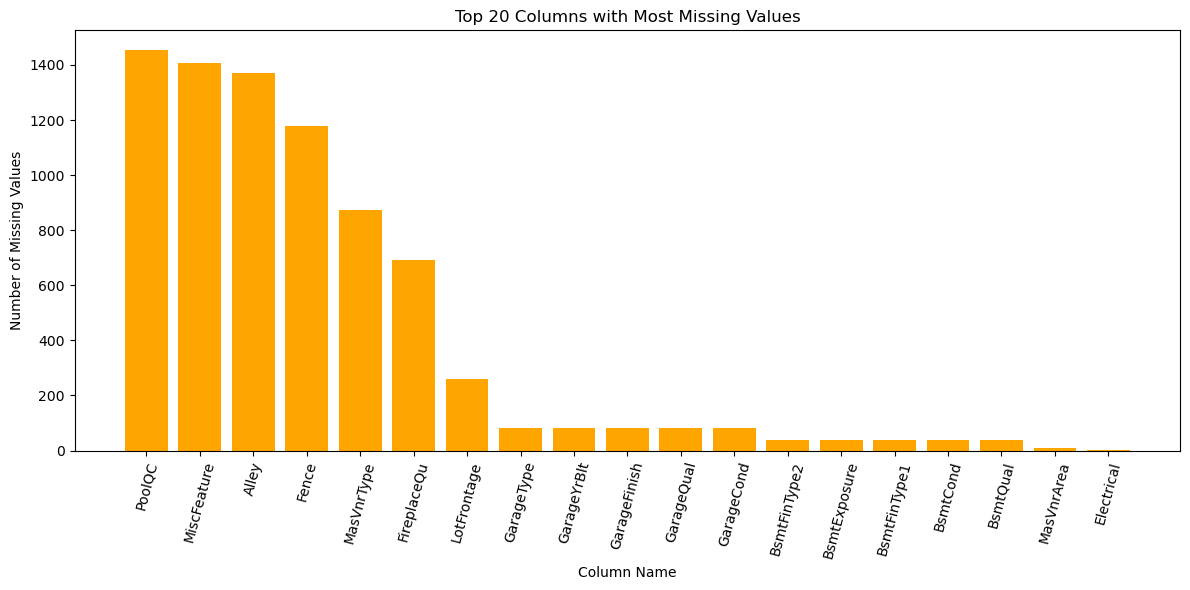

In [62]:
# 1. Her sütundaki eksik değer sayısını bul
missing_counts = train_df.isnull().sum()

# 2. Eksik değeri olan sütunları ve oranlarını bul, en çok eksik olan ilk 20 sütunu seç
missing_percent = (missing_counts / len(train_df)) * 100
missing_df = pd.DataFrame({
    'MissingCount': missing_counts,
    'MissingPercent': missing_percent
})
missing_df = missing_df[missing_df['MissingCount'] > 0]
missing_df = missing_df.sort_values(by='MissingCount', ascending=False).head(20)

# 3. Sonuçları yazdır
print(missing_df)

# 4. Bar plot ile görselleştir
plt.figure(figsize=(12,6))
plt.bar(missing_df.index, missing_df['MissingCount'], color='orange')
plt.xticks(rotation=75)
plt.title('Top 20 Columns with Most Missing Values')
plt.ylabel('Number of Missing Values')
plt.xlabel('Column Name')
plt.tight_layout()
plt.show()

**3. Correlation Analysis (Numerical)**

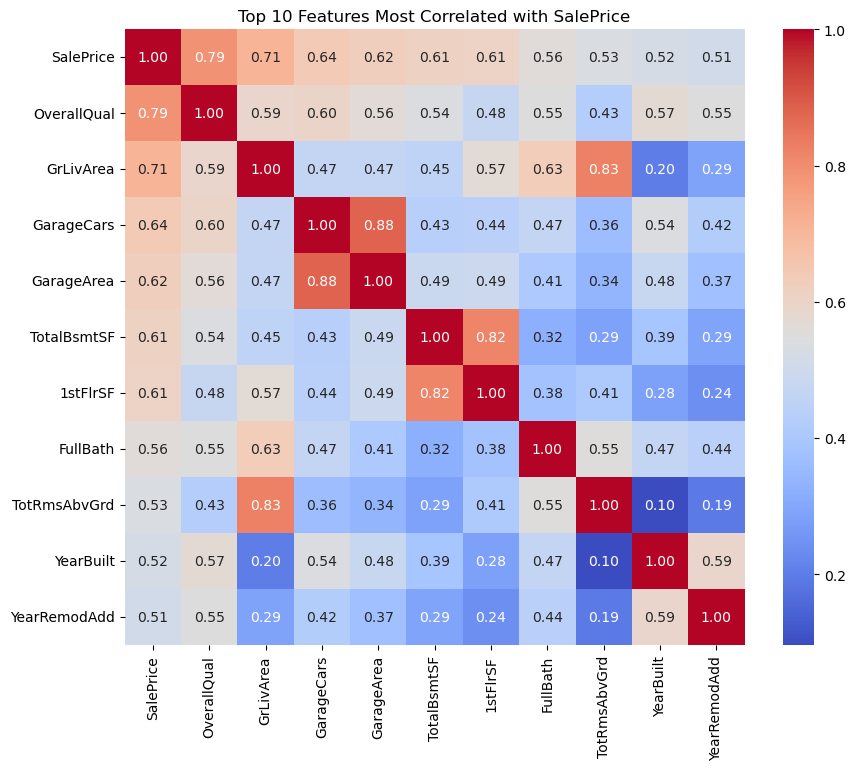

In [63]:


# Sadece sayısal sütunları seç
numeric_cols = train_df.select_dtypes(include=['number'])

# Korelasyon matrisini hesapla
corr_matrix = numeric_cols.corr()

# SalePrice ile en yüksek korelasyona sahip 10 özelliği bul
top_corr_features = corr_matrix['SalePrice'].abs().sort_values(ascending=False).head(11).index  # 11 çünkü SalePrice kendisi de dahil

# Bu özelliklerin korelasyon matrisini al
top_corr_matrix = corr_matrix.loc[top_corr_features, top_corr_features]

# Isı haritası çiz
plt.figure(figsize=(10,8))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Top 10 Features Most Correlated with SalePrice')
plt.show()

**4. Feature vs. SalePrice Visualizations**

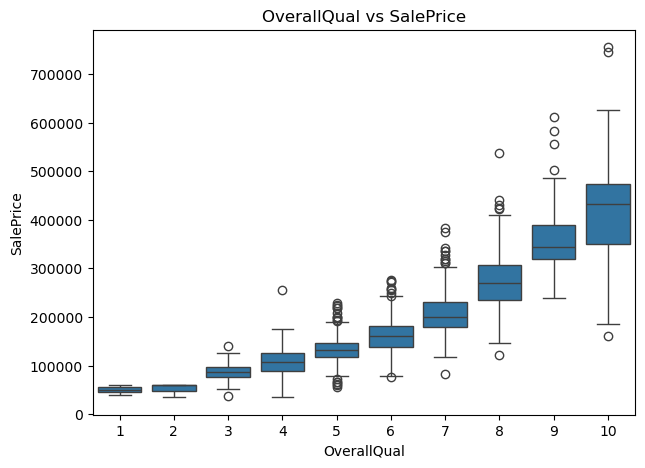

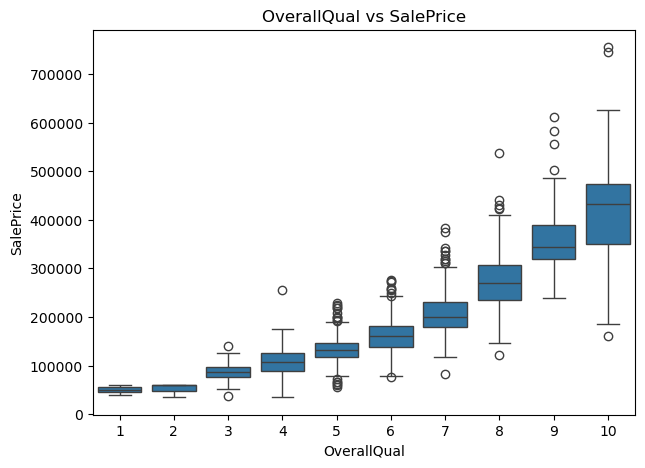

Yorum: Genel malzeme ve işçilik kalitesi (OverallQual) arttıkça, evin satış fiyatı da belirgin şekilde artıyor.


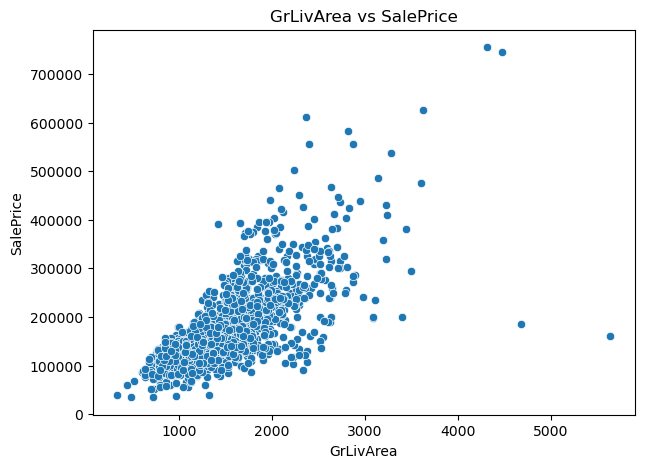

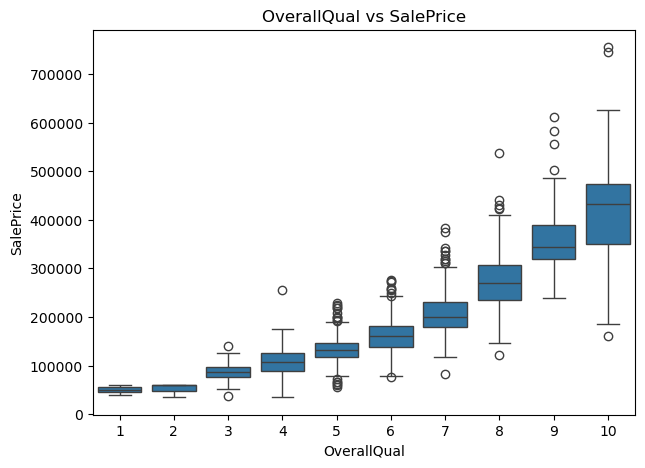

Yorum: Genel malzeme ve işçilik kalitesi (OverallQual) arttıkça, evin satış fiyatı da belirgin şekilde artıyor.


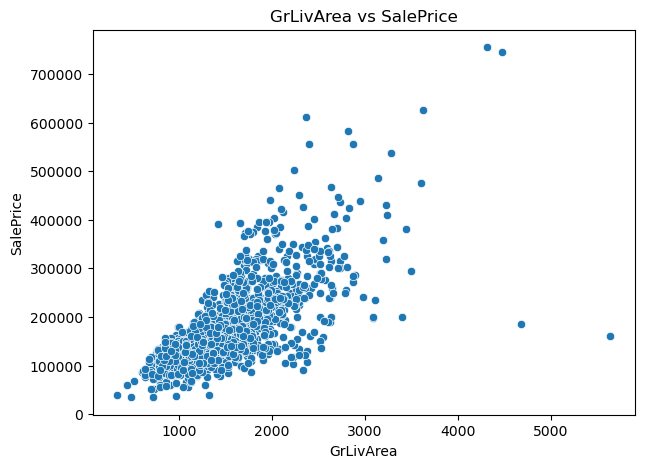

Yorum: Yaşanabilir alan (GrLivArea) arttıkça, satış fiyatı da genellikle artıyor. Ancak bazı uç değerler (outlier) gözlemleniyor.


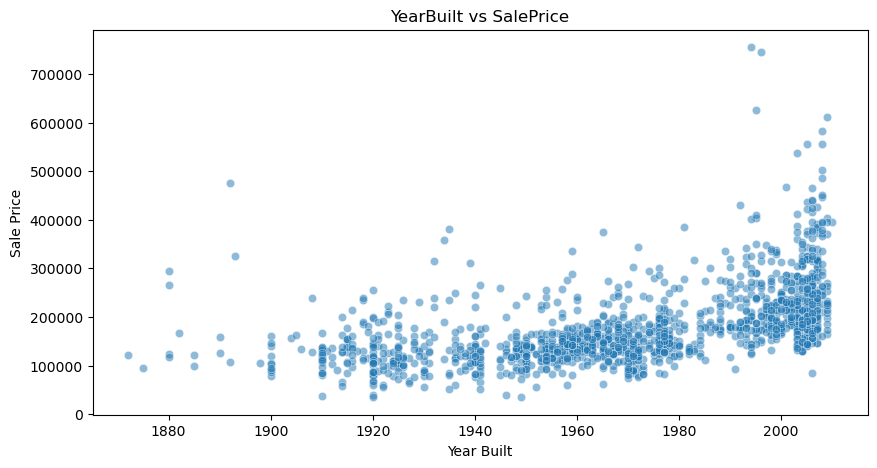

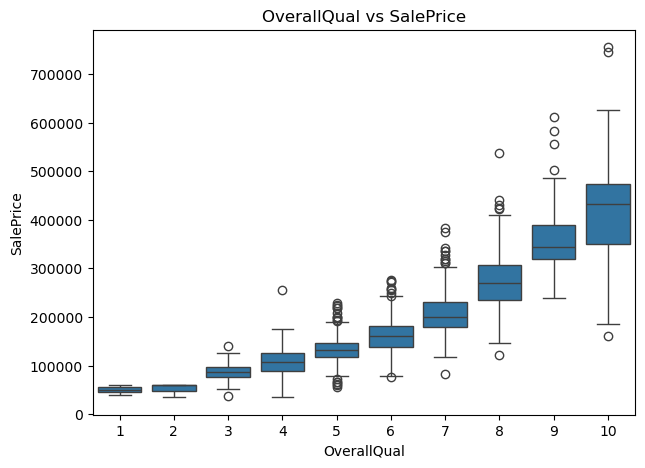

Yorum: Genel malzeme ve işçilik kalitesi (OverallQual) arttıkça, evin satış fiyatı da belirgin şekilde artıyor.


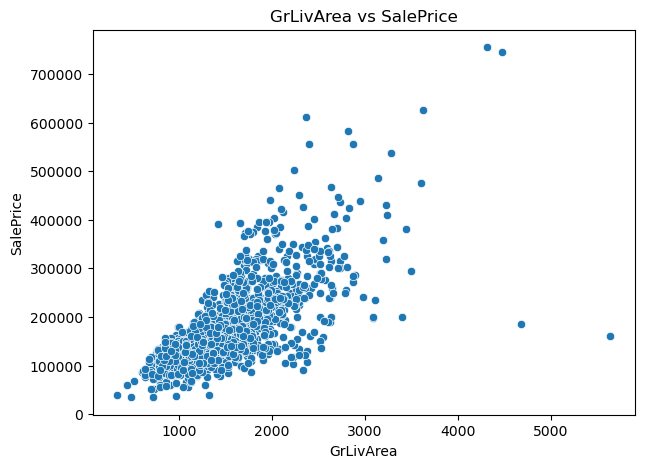

Yorum: Yaşanabilir alan (GrLivArea) arttıkça, satış fiyatı da genellikle artıyor. Ancak bazı uç değerler (outlier) gözlemleniyor.


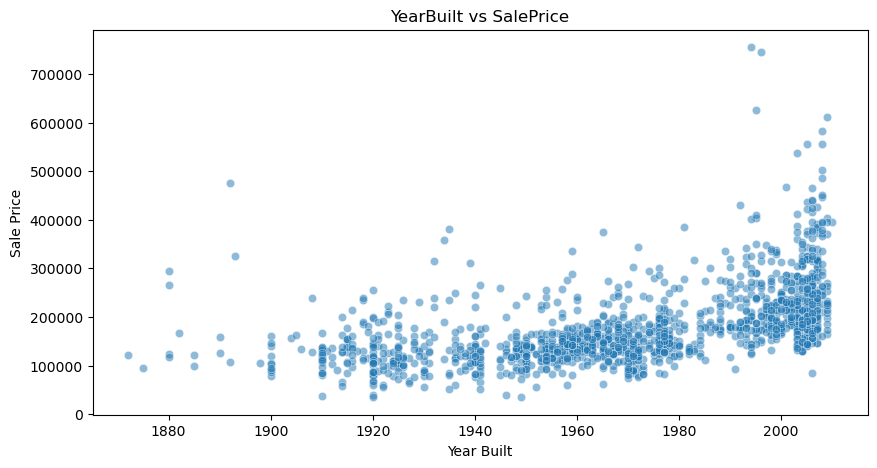

Yorum: Daha yeni inşa edilen evlerin satış fiyatı genellikle daha yüksek. Zamanla fiyatlarda artış eğilimi var.


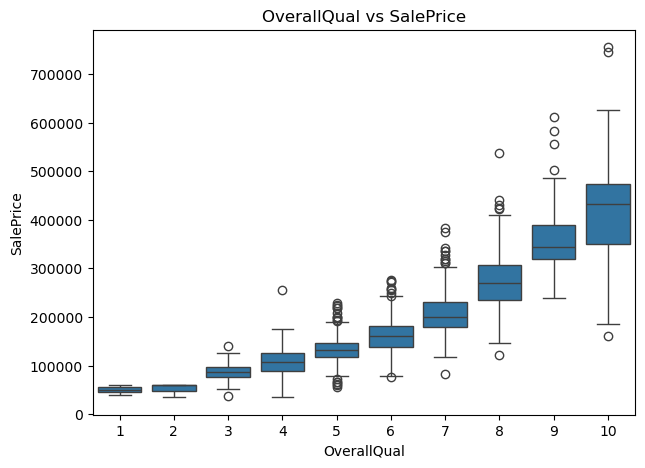

Yorum: Genel malzeme ve işçilik kalitesi (OverallQual) arttıkça, evin satış fiyatı da belirgin şekilde artıyor.


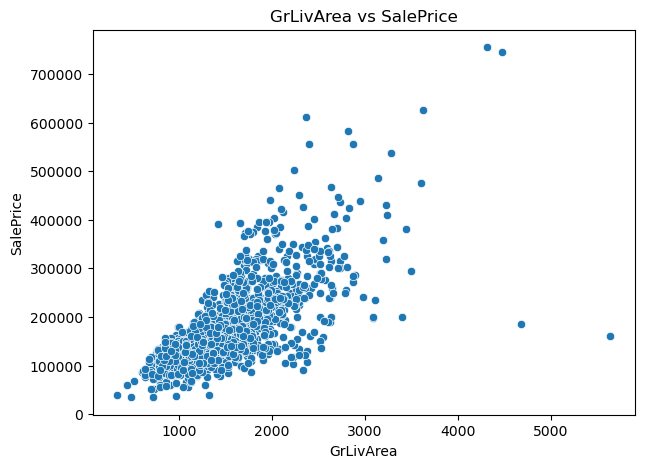

Yorum: Yaşanabilir alan (GrLivArea) arttıkça, satış fiyatı da genellikle artıyor. Ancak bazı uç değerler (outlier) gözlemleniyor.


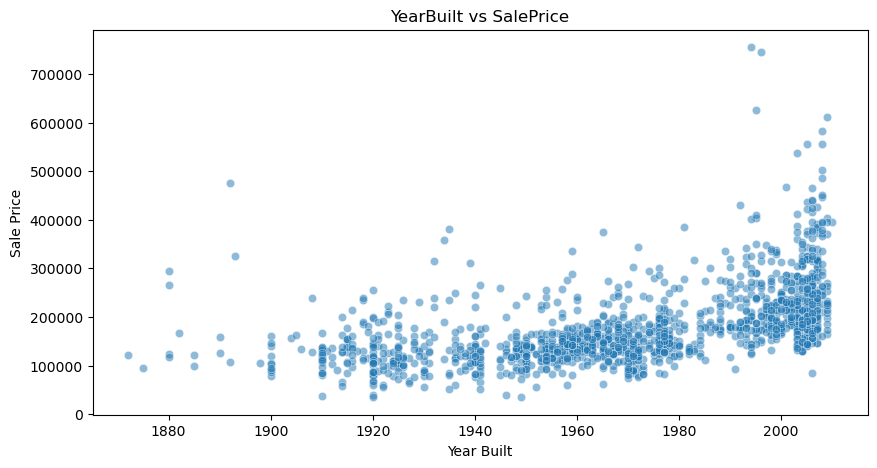

Yorum: Daha yeni inşa edilen evlerin satış fiyatı genellikle daha yüksek. Zamanla fiyatlarda artış eğilimi var.


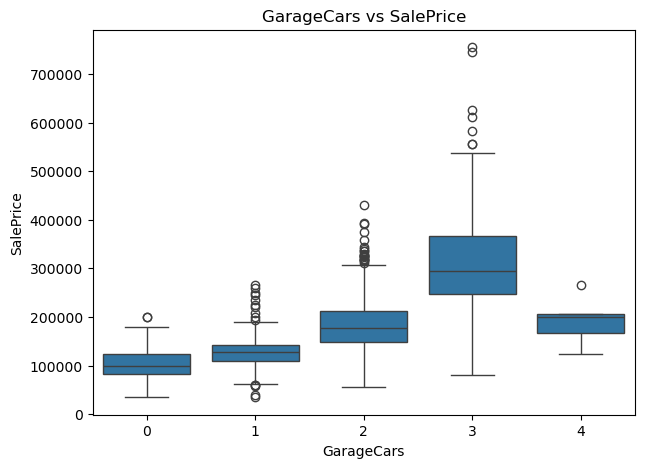

Yorum: Garaj kapasitesi arttıkça, evin satış fiyatı da artma eğiliminde. 3 veya daha fazla araçlık garajlar yüksek fiyatlarla ilişkilendiriliyor.


In [64]:
# 1. OverallQual vs SalePrice
plt.figure(figsize=(7,5))
sns.boxplot(x='OverallQual', y='SalePrice', data=train_df)
plt.title('OverallQual vs SalePrice')
plt.show()
print("Yorum: Genel malzeme ve işçilik kalitesi (OverallQual) arttıkça, evin satış fiyatı da belirgin şekilde artıyor.")

# 2. GrLivArea vs SalePrice
plt.figure(figsize=(7,5))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_df)
plt.title('GrLivArea vs SalePrice')
plt.show()
print("Yorum: Yaşanabilir alan (GrLivArea) arttıkça, satış fiyatı da genellikle artıyor. Ancak bazı uç değerler (outlier) gözlemleniyor.")

# 3. YearBuilt vs SalePrice - Scatter plot ile daha iyi görselleştirme
plt.figure(figsize=(10,5))
sns.scatterplot(x='YearBuilt', y='SalePrice', data=train_df, alpha=0.5)
plt.title('YearBuilt vs SalePrice')
plt.xlabel('Year Built')
plt.ylabel('Sale Price')
plt.show()
print("Yorum: Daha yeni inşa edilen evlerin satış fiyatı genellikle daha yüksek. Zamanla fiyatlarda artış eğilimi var.")

# 4. GarageCars vs SalePrice
plt.figure(figsize=(7,5))
sns.boxplot(x='GarageCars', y='SalePrice', data=train_df)
plt.title('GarageCars vs SalePrice')
plt.show()
print("Yorum: Garaj kapasitesi arttıkça, evin satış fiyatı da artma eğiliminde. 3 veya daha fazla araçlık garajlar yüksek fiyatlarla ilişkilendiriliyor.")

**C) Data Cleaning**

In [65]:
# 1. Numerical columns: Fill missing values with median
num_cols = train_df.select_dtypes(include=['number']).columns
for col in num_cols:
    if col != 'SalePrice':  # SalePrice'ı doldurma
        median = train_df[col].median()
        train_df[col] = train_df[col].fillna(median)
        if col in test_df.columns:
            test_df[col] = test_df[col].fillna(median)

# 2. Categorical columns: Fill missing values with 'None' or most frequent
cat_cols = train_df.select_dtypes(include=['object']).columns
for col in cat_cols:
    if col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'Alley', 'FireplaceQu', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']:
        train_df[col] = train_df[col].fillna('None')
        if col in test_df.columns:
            test_df[col] = test_df[col].fillna('None')
    else:
        # Mode'u kontrol et ve boş değilse doldur
        mode_values = train_df[col].mode()
        if len(mode_values) > 0:
            mode = mode_values[0]
            train_df[col] = train_df[col].fillna(mode)
            if col in test_df.columns:
                test_df[col] = test_df[col].fillna(mode)
        else:
            # Eğer mode yoksa 'Unknown' ile doldur
            train_df[col] = train_df[col].fillna('Unknown')
            if col in test_df.columns:
                test_df[col] = test_df[col].fillna('Unknown')

# Kontrol: Kalan eksik değerleri kontrol et
print("Train set'te kalan eksik değerler:")
print(train_df.isnull().sum()[train_df.isnull().sum() > 0])
print("\nTest set'te kalan eksik değerler:")
print(test_df.isnull().sum()[test_df.isnull().sum() > 0])

Train set'te kalan eksik değerler:
Series([], dtype: int64)

Test set'te kalan eksik değerler:
Series([], dtype: int64)


**2) Outlier Handling**

Before outlier removal - Train shape: (1460, 81)

Anomalies found (GrLivArea > 4000 and SalePrice < 300000): 2
      GrLivArea  SalePrice
523        4676     184750
1298       5642     160000

SalePrice IQR bounds: [3812, 340112]
Outliers detected by IQR method: 61

After outlier removal - Train shape: (1420, 81)
Rows removed: 40


Before outlier removal - Train shape: (1460, 81)

Anomalies found (GrLivArea > 4000 and SalePrice < 300000): 2
      GrLivArea  SalePrice
523        4676     184750
1298       5642     160000

SalePrice IQR bounds: [3812, 340112]
Outliers detected by IQR method: 61

After outlier removal - Train shape: (1420, 81)
Rows removed: 40


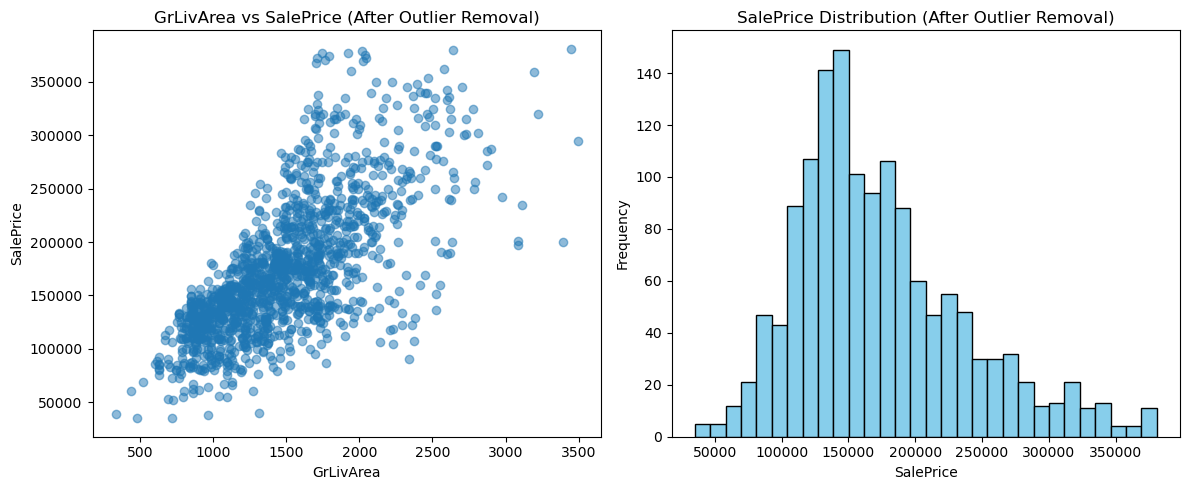


✓ Outlier handling completed successfully!


In [66]:
# 1. Identify and remove outliers where GrLivArea is high but SalePrice is low
# These are likely data entry errors
print("Before outlier removal - Train shape:", train_df.shape)

# Method 1: Remove anomalies where GrLivArea > 4000 but SalePrice < 300000
outliers_grliv = train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 300000)]
print(f"\nAnomalies found (GrLivArea > 4000 and SalePrice < 300000): {len(outliers_grliv)}")
print(outliers_grliv[['GrLivArea', 'SalePrice']])

# Remove these anomalies
train_df = train_df[~((train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 300000))]

# Method 2: IQR method for SalePrice (remove extreme values)
Q1_price = train_df['SalePrice'].quantile(0.25)
Q3_price = train_df['SalePrice'].quantile(0.75)
IQR_price = Q3_price - Q1_price

# Define outliers as beyond 1.5*IQR
lower_bound = Q1_price - 1.5 * IQR_price
upper_bound = Q3_price + 1.5 * IQR_price

print(f"\nSalePrice IQR bounds: [{lower_bound:.0f}, {upper_bound:.0f}]")
outliers_iqr = train_df[(train_df['SalePrice'] < lower_bound) | (train_df['SalePrice'] > upper_bound)]
print(f"Outliers detected by IQR method: {len(outliers_iqr)}")

# Optional: Remove extreme outliers (keeping moderate outliers for learning)
# Keeping only moderate outliers (1.5-2.0 * IQR range)
train_df = train_df[~((train_df['SalePrice'] < Q1_price - 2 * IQR_price) | 
                      (train_df['SalePrice'] > Q3_price + 2 * IQR_price))]

print(f"\nAfter outlier removal - Train shape: {train_df.shape}")
print(f"Rows removed: {1460 - len(train_df)}")

# Visualize the cleaned data
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(train_df['GrLivArea'], train_df['SalePrice'], alpha=0.5)
plt.title('GrLivArea vs SalePrice (After Outlier Removal)')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')

plt.subplot(1, 2, 2)
plt.hist(train_df['SalePrice'], bins=30, color='skyblue', edgecolor='black')
plt.title('SalePrice Distribution (After Outlier Removal)')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\n✓ Outlier handling completed successfully!")

**E) Feature Engineering**

In [67]:
# Create 5+ new engineered features

# 1. TotalSF: Total square footage combining basement, first floor, and second floor
train_df['TotalSF'] = train_df['TotalBsmtSF'] + train_df['1stFlrSF'] + train_df['2ndFlrSF']
test_df['TotalSF'] = test_df['TotalBsmtSF'] + test_df['1stFlrSF'] + test_df['2ndFlrSF']
print("✓ Feature 1 - TotalSF: This aggregates all usable square footage, which is often a strong predictor of house price.")

# 2. HouseAge: Age of the house at the time of sale
train_df['HouseAge'] = train_df['YrSold'] - train_df['YearBuilt']
test_df['HouseAge'] = test_df['YrSold'] - test_df['YearBuilt']
print("✓ Feature 2 - HouseAge: Newer houses typically command higher prices due to modern construction standards and fewer maintenance needs.")

# 3. RemodAge: Years since the house was remodeled
train_df['RemodAge'] = train_df['YrSold'] - train_df['YearRemodAdd']
test_df['RemodAge'] = test_df['YrSold'] - test_df['YearRemodAdd']
print("✓ Feature 3 - RemodAge: Recent renovations significantly impact property value, making this a useful predictor.")

# 4. TotalBathrooms: Total number of bathrooms (full + half + basement bathrooms)
train_df['TotalBathrooms'] = (train_df['FullBath'] + 0.5 * train_df['HalfBath'] + 
                               train_df['BsmtFullBath'] + 0.5 * train_df['BsmtHalfBath'])
test_df['TotalBathrooms'] = (test_df['FullBath'] + 0.5 * test_df['HalfBath'] + 
                              test_df['BsmtFullBath'] + 0.5 * test_df['BsmtHalfBath'])
print("✓ Feature 4 - TotalBathrooms: The total number of bathrooms is a key amenity affecting home valuation.")

# 5. TotalPorchSF: Combined outdoor living space from all porch types
train_df['TotalPorchSF'] = (train_df['OpenPorchSF'] + train_df['EnclosedPorch'] + 
                             train_df['3SsnPorch'] + train_df['ScreenPorch'])
test_df['TotalPorchSF'] = (test_df['OpenPorchSF'] + test_df['EnclosedPorch'] + 
                            test_df['3SsnPorch'] + test_df['ScreenPorch'])
print("✓ Feature 5 - TotalPorchSF: Outdoor living space enhances desirability and increases overall property value.")

# BONUS: Additional useful features
# 6. LotRatio: Ratio of building area to lot area (how efficiently the lot is used)
train_df['LotRatio'] = train_df['TotalSF'] / (train_df['LotArea'] + 1)  # +1 to avoid division by zero
test_df['LotRatio'] = test_df['TotalSF'] / (test_df['LotArea'] + 1)
print("✓ Feature 6 - LotRatio: Higher building-to-lot ratios indicate better land utilization and may correlate with price.")

# 7. GarageAge: Age of the garage (newer garages add value)
train_df['GarageAge'] = train_df['YrSold'] - train_df['GarageYrBlt'].fillna(train_df['YearBuilt'])
test_df['GarageAge'] = test_df['YrSold'] - test_df['GarageYrBlt'].fillna(test_df['YearBuilt'])
print("✓ Feature 7 - GarageAge: More recent garages are typically in better condition, affecting home value.")

# Display summary of new features
print("\n" + "="*60)
print("FEATURE ENGINEERING SUMMARY")
print("="*60)
print(f"\nNew features created:")
new_features = ['TotalSF', 'HouseAge', 'RemodAge', 'TotalBathrooms', 'TotalPorchSF', 'LotRatio', 'GarageAge']
for i, feat in enumerate(new_features, 1):
    print(f"  {i}. {feat}")

print(f"\nTrain set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

# Show statistics of new features
print("\n" + "="*60)
print("NEW FEATURES STATISTICS")
print("="*60)
print(train_df[new_features].describe())

✓ Feature 1 - TotalSF: This aggregates all usable square footage, which is often a strong predictor of house price.
✓ Feature 2 - HouseAge: Newer houses typically command higher prices due to modern construction standards and fewer maintenance needs.
✓ Feature 3 - RemodAge: Recent renovations significantly impact property value, making this a useful predictor.
✓ Feature 4 - TotalBathrooms: The total number of bathrooms is a key amenity affecting home valuation.
✓ Feature 5 - TotalPorchSF: Outdoor living space enhances desirability and increases overall property value.
✓ Feature 6 - LotRatio: Higher building-to-lot ratios indicate better land utilization and may correlate with price.
✓ Feature 7 - GarageAge: More recent garages are typically in better condition, affecting home value.

FEATURE ENGINEERING SUMMARY

New features created:
  1. TotalSF
  2. HouseAge
  3. RemodAge
  4. TotalBathrooms
  5. TotalPorchSF
  6. LotRatio
  7. GarageAge

Train set shape: (1420, 88)
Test set shape: (

**F) Preprocessing Pipeline**

In [68]:
# Prepare data for modeling
# Separate features and target variable
X_train = train_df.drop('SalePrice', axis=1)
y_train = train_df['SalePrice']
X_test = test_df.copy()

print("="*60)
print("DATA PREPARATION FOR MODELING")
print("="*60)
print(f"\nX_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")

# Step 1: Identify numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumerical columns ({len(numerical_cols)}): {numerical_cols[:5]}...")
print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols[:5]}...")

# Step 2: Create preprocessing pipeline using ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Numerical preprocessing: Impute missing values + Scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical preprocessing: Impute missing values + One-Hot Encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

print("\n" + "="*60)
print("PREPROCESSING PIPELINE CREATED")
print("="*60)
print("\nNumerical Transformer:")
print("  - Strategy: Median imputation + Standard scaling")
print("\nCategorical Transformer:")
print("  - Strategy: Most frequent imputation + One-Hot encoding")

# Step 3: Apply preprocessing to training data
print("\nFitting preprocessor on training data...")
X_train_processed = preprocessor.fit_transform(X_train)
print(f"✓ X_train_processed shape: {X_train_processed.shape}")

# Step 4: Apply preprocessing to test data
print("Transforming test data...")
X_test_processed = preprocessor.transform(X_test)
print(f"✓ X_test_processed shape: {X_test_processed.shape}")

# Display feature names after preprocessing
feature_names = (numerical_cols + 
                 list(preprocessor.named_transformers_['cat']
                 .named_steps['onehot'].get_feature_names_out(categorical_cols)))

print(f"\n✓ Total features after preprocessing: {len(feature_names)}")
print(f"  - Numerical features: {len(numerical_cols)}")
print(f"  - Categorical features (after encoding): {X_train_processed.shape[1] - len(numerical_cols)}")

# Convert to DataFrame for easier handling (optional but recommended)
X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names)

print("\n" + "="*60)
print("✓ PREPROCESSING PIPELINE COMPLETED!")
print("="*60)
print(f"\nProcessed training data shape: {X_train_processed_df.shape}")
print(f"Processed test data shape: {X_test_processed_df.shape}")
print(f"Target variable (y_train) shape: {y_train.shape}")

DATA PREPARATION FOR MODELING

X_train shape: (1420, 87)
y_train shape: (1420,)
X_test shape: (1459, 87)

Numerical columns (44): ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual']...
Categorical columns (43): ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour']...

PREPROCESSING PIPELINE CREATED

Numerical Transformer:
  - Strategy: Median imputation + Standard scaling

Categorical Transformer:
  - Strategy: Most frequent imputation + One-Hot encoding

Fitting preprocessor on training data...
✓ X_train_processed shape: (1420, 308)
Transforming test data...
✓ X_test_processed shape: (1459, 308)

✓ Total features after preprocessing: 308
  - Numerical features: 44
  - Categorical features (after encoding): 264

✓ PREPROCESSING PIPELINE COMPLETED!

Processed training data shape: (1420, 308)
Processed test data shape: (1459, 308)
Target variable (y_train) shape: (1420,)


**G) Model Training & Evaluation**

MODEL TRAINING & EVALUATION WITH 3 REGRESSION MODELS

MODEL 1: RIDGE REGRESSION

✓ Ridge Regression Results:
  - Training R² Score: 0.9435
  - Training RMSE: $15,126.24
  - Training MAE: $10,914.95
  - CV R² Mean: 0.9095 (+/- 0.0067)

MODEL 2: RANDOM FOREST REGRESSOR

✓ Random Forest Regressor Results:
  - Training R² Score: 0.9771
  - Training RMSE: $9,637.84
  - Training MAE: $6,332.91
  - CV R² Mean: 0.8837 (+/- 0.0174)

MODEL 3: GRADIENT BOOSTING REGRESSOR

✓ Gradient Boosting Regressor Results:
  - Training R² Score: 0.9963
  - Training RMSE: $3,846.17
  - Training MAE: $3,012.53
  - CV R² Mean: 0.9076 (+/- 0.0121)

MODEL COMPARISON SUMMARY

                   R² Score          RMSE           MAE  CV R² Mean  CV R² Std
Ridge              0.943501  15126.237985  10914.952776    0.909508   0.006697
Random Forest      0.977063   9637.842765   6332.906448    0.883731   0.017433
Gradient Boosting  0.996347   3846.166419   3012.534592    0.907608   0.012130

🏆 BEST MODEL (by CV R² Mean)

MODEL TRAINING & EVALUATION WITH 3 REGRESSION MODELS

MODEL 1: RIDGE REGRESSION

✓ Ridge Regression Results:
  - Training R² Score: 0.9435
  - Training RMSE: $15,126.24
  - Training MAE: $10,914.95
  - CV R² Mean: 0.9095 (+/- 0.0067)

MODEL 2: RANDOM FOREST REGRESSOR

✓ Random Forest Regressor Results:
  - Training R² Score: 0.9771
  - Training RMSE: $9,637.84
  - Training MAE: $6,332.91
  - CV R² Mean: 0.8837 (+/- 0.0174)

MODEL 3: GRADIENT BOOSTING REGRESSOR

✓ Gradient Boosting Regressor Results:
  - Training R² Score: 0.9963
  - Training RMSE: $3,846.17
  - Training MAE: $3,012.53
  - CV R² Mean: 0.9076 (+/- 0.0121)

MODEL COMPARISON SUMMARY

                   R² Score          RMSE           MAE  CV R² Mean  CV R² Std
Ridge              0.943501  15126.237985  10914.952776    0.909508   0.006697
Random Forest      0.977063   9637.842765   6332.906448    0.883731   0.017433
Gradient Boosting  0.996347   3846.166419   3012.534592    0.907608   0.012130

🏆 BEST MODEL (by CV R² Mean)

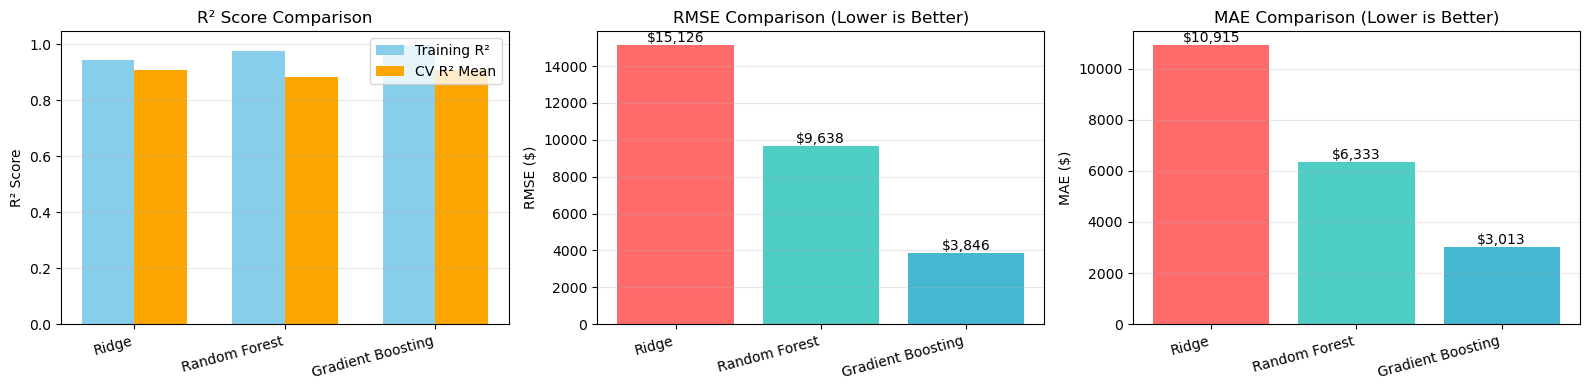


✓ Model Training & Evaluation Completed!


In [69]:
# Import additional models and utilities
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_validate, KFold
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("MODEL TRAINING & EVALUATION WITH 3 REGRESSION MODELS")
print("="*80)

# Define K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Dictionary to store models and their performance
models = {}
results = {}

# ============================================================================
# MODEL 1: RIDGE REGRESSION (Linear Model with L2 Regularization)
# ============================================================================
print("\n" + "="*80)
print("MODEL 1: RIDGE REGRESSION")
print("="*80)

ridge_model = Ridge(alpha=1.0, random_state=42)

# Cross-validation
ridge_cv = cross_validate(ridge_model, X_train_processed_df, y_train, 
                          cv=kfold, scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'],
                          return_train_score=True)

# Train on full training data
ridge_model.fit(X_train_processed_df, y_train)

# Predictions
ridge_train_pred = ridge_model.predict(X_train_processed_df)
ridge_test_pred = ridge_model.predict(X_test_processed_df)

# Metrics
ridge_r2 = ridge_model.score(X_train_processed_df, y_train)
ridge_rmse = np.sqrt(mean_squared_error(y_train, ridge_train_pred))
ridge_mae = mean_absolute_error(y_train, ridge_train_pred)

results['Ridge'] = {
    'R² Score': ridge_r2,
    'RMSE': ridge_rmse,
    'MAE': ridge_mae,
    'CV R² Mean': ridge_cv['test_r2'].mean(),
    'CV R² Std': ridge_cv['test_r2'].std()
}

print(f"\n✓ Ridge Regression Results:")
print(f"  - Training R² Score: {ridge_r2:.4f}")
print(f"  - Training RMSE: ${ridge_rmse:,.2f}")
print(f"  - Training MAE: ${ridge_mae:,.2f}")
print(f"  - CV R² Mean: {ridge_cv['test_r2'].mean():.4f} (+/- {ridge_cv['test_r2'].std():.4f})")

models['Ridge'] = ridge_model

# ============================================================================
# MODEL 2: RANDOM FOREST REGRESSOR (Ensemble Tree-Based Model)
# ============================================================================
print("\n" + "="*80)
print("MODEL 2: RANDOM FOREST REGRESSOR")
print("="*80)

rf_model = RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=5,
                                  min_samples_leaf=2, random_state=42, n_jobs=-1)

# Cross-validation
rf_cv = cross_validate(rf_model, X_train_processed_df, y_train,
                       cv=kfold, scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'],
                       return_train_score=True)

# Train on full training data
rf_model.fit(X_train_processed_df, y_train)

# Predictions
rf_train_pred = rf_model.predict(X_train_processed_df)
rf_test_pred = rf_model.predict(X_test_processed_df)

# Metrics
rf_r2 = rf_model.score(X_train_processed_df, y_train)
rf_rmse = np.sqrt(mean_squared_error(y_train, rf_train_pred))
rf_mae = mean_absolute_error(y_train, rf_train_pred)

results['Random Forest'] = {
    'R² Score': rf_r2,
    'RMSE': rf_rmse,
    'MAE': rf_mae,
    'CV R² Mean': rf_cv['test_r2'].mean(),
    'CV R² Std': rf_cv['test_r2'].std()
}

print(f"\n✓ Random Forest Regressor Results:")
print(f"  - Training R² Score: {rf_r2:.4f}")
print(f"  - Training RMSE: ${rf_rmse:,.2f}")
print(f"  - Training MAE: ${rf_mae:,.2f}")
print(f"  - CV R² Mean: {rf_cv['test_r2'].mean():.4f} (+/- {rf_cv['test_r2'].std():.4f})")

models['Random Forest'] = rf_model

# ============================================================================
# MODEL 3: GRADIENT BOOSTING REGRESSOR (Sequential Ensemble Model)
# ============================================================================
print("\n" + "="*80)
print("MODEL 3: GRADIENT BOOSTING REGRESSOR")
print("="*80)

gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5,
                                      min_samples_split=5, min_samples_leaf=2,
                                      random_state=42, subsample=0.8)

# Cross-validation
gb_cv = cross_validate(gb_model, X_train_processed_df, y_train,
                       cv=kfold, scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'],
                       return_train_score=True)

# Train on full training data
gb_model.fit(X_train_processed_df, y_train)

# Predictions
gb_train_pred = gb_model.predict(X_train_processed_df)
gb_test_pred = gb_model.predict(X_test_processed_df)

# Metrics
gb_r2 = gb_model.score(X_train_processed_df, y_train)
gb_rmse = np.sqrt(mean_squared_error(y_train, gb_train_pred))
gb_mae = mean_absolute_error(y_train, gb_train_pred)

results['Gradient Boosting'] = {
    'R² Score': gb_r2,
    'RMSE': gb_rmse,
    'MAE': gb_mae,
    'CV R² Mean': gb_cv['test_r2'].mean(),
    'CV R² Std': gb_cv['test_r2'].std()
}

print(f"\n✓ Gradient Boosting Regressor Results:")
print(f"  - Training R² Score: {gb_r2:.4f}")
print(f"  - Training RMSE: ${gb_rmse:,.2f}")
print(f"  - Training MAE: ${gb_mae:,.2f}")
print(f"  - CV R² Mean: {gb_cv['test_r2'].mean():.4f} (+/- {gb_cv['test_r2'].std():.4f})")

models['Gradient Boosting'] = gb_model

# ============================================================================
# COMPARISON & VISUALIZATION
# ============================================================================
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)

# Create comparison DataFrame
comparison_df = pd.DataFrame(results).T
print("\n" + comparison_df.to_string())

# Find best model
best_model_name = comparison_df['CV R² Mean'].idxmax()
best_r2 = comparison_df['CV R² Mean'].max()

print(f"\n🏆 BEST MODEL (by CV R² Mean): {best_model_name} with R² = {best_r2:.4f}")

# Visualization: Model Performance Comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# R² Score Comparison
model_names = list(results.keys())
r2_scores = [results[m]['R² Score'] for m in model_names]
cv_r2_means = [results[m]['CV R² Mean'] for m in model_names]

x = np.arange(len(model_names))
width = 0.35

axes[0].bar(x - width/2, r2_scores, width, label='Training R²', color='skyblue')
axes[0].bar(x + width/2, cv_r2_means, width, label='CV R² Mean', color='orange')
axes[0].set_ylabel('R² Score')
axes[0].set_title('R² Score Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(model_names, rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# RMSE Comparison
rmse_scores = [results[m]['RMSE'] for m in model_names]
axes[1].bar(model_names, rmse_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1].set_ylabel('RMSE ($)')
axes[1].set_title('RMSE Comparison (Lower is Better)')
axes[1].set_xticklabels(model_names, rotation=15, ha='right')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(rmse_scores):
    axes[1].text(i, v, f'${v:,.0f}', ha='center', va='bottom')

# MAE Comparison
mae_scores = [results[m]['MAE'] for m in model_names]
axes[2].bar(model_names, mae_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[2].set_ylabel('MAE ($)')
axes[2].set_title('MAE Comparison (Lower is Better)')
axes[2].set_xticklabels(model_names, rotation=15, ha='right')
axes[2].grid(axis='y', alpha=0.3)
for i, v in enumerate(mae_scores):
    axes[2].text(i, v, f'${v:,.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\n✓ Model Training & Evaluation Completed!")

**H) Final Evaluation with Log-Transformed Target (Kaggle Metric)**


FINAL EVALUATION WITH LOG-TRANSFORMED TARGET (KAGGLE METRIC)

Note: Kaggle uses log-based error metric. Using y = log1p(SalePrice)
This is more robust to outliers and aligns with Kaggle competition scoring.

Original y_train range: $34,900 - $381,000
Log-transformed y_train range: 10.4603 - 12.8506

RE-TRAINING MODELS WITH LOG-TRANSFORMED TARGET

--------------------------------------------------------------------------------
MODEL 1: RIDGE REGRESSION (Log-Transformed)
--------------------------------------------------------------------------------

✓ Ridge Regression (Log-Transformed):
  - CV RMSE Mean: 0.117349
  - CV RMSE Std:  0.010565
  - Training RMSE: 0.090115
  - CV R² Mean: 0.8972
  - CV R² Std:  0.0119

--------------------------------------------------------------------------------
MODEL 2: RANDOM FOREST REGRESSOR (Log-Transformed)
--------------------------------------------------------------------------------

✓ Random Forest Regressor (Log-Transformed):
  - CV RMSE Mean:


FINAL EVALUATION WITH LOG-TRANSFORMED TARGET (KAGGLE METRIC)

Note: Kaggle uses log-based error metric. Using y = log1p(SalePrice)
This is more robust to outliers and aligns with Kaggle competition scoring.

Original y_train range: $34,900 - $381,000
Log-transformed y_train range: 10.4603 - 12.8506

RE-TRAINING MODELS WITH LOG-TRANSFORMED TARGET

--------------------------------------------------------------------------------
MODEL 1: RIDGE REGRESSION (Log-Transformed)
--------------------------------------------------------------------------------

✓ Ridge Regression (Log-Transformed):
  - CV RMSE Mean: 0.117349
  - CV RMSE Std:  0.010565
  - Training RMSE: 0.090115
  - CV R² Mean: 0.8972
  - CV R² Std:  0.0119

--------------------------------------------------------------------------------
MODEL 2: RANDOM FOREST REGRESSOR (Log-Transformed)
--------------------------------------------------------------------------------

✓ Random Forest Regressor (Log-Transformed):
  - CV RMSE Mean:

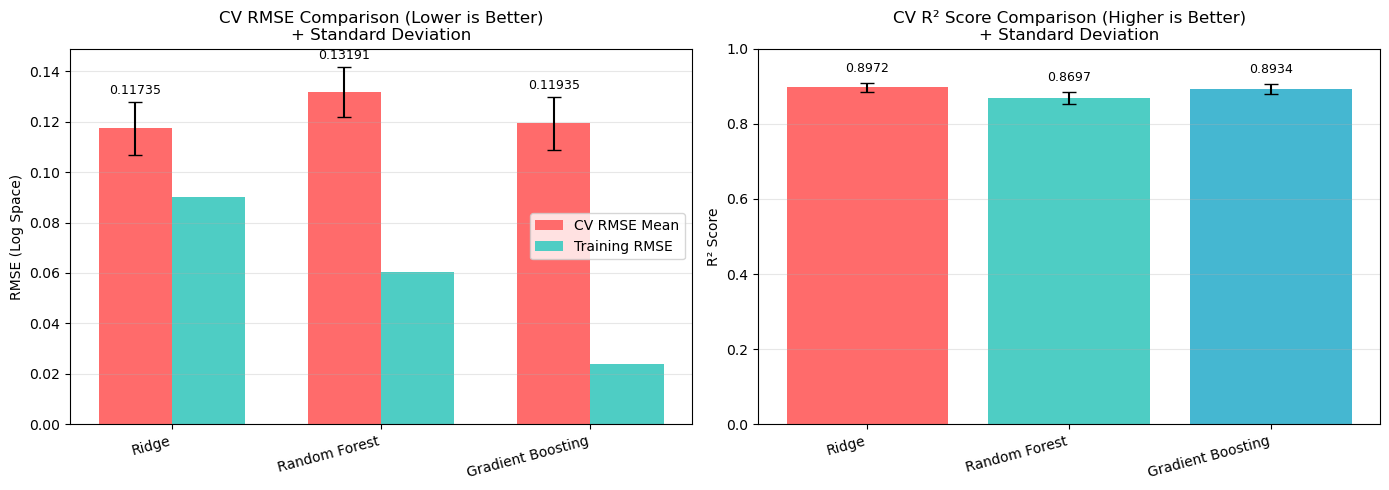


✓ Final Evaluation Completed!

KAGGLE SUBMISSION READY

Best model for Kaggle submission: Ridge
Expected CV RMSE (Log Space): 0.117349 (+/- 0.010565)


In [70]:
# Kaggle Competition Metric: Log-based RMSE (RMSLE)
# Transform target variable using log1p for better modeling

print("\n" + "="*80)
print("FINAL EVALUATION WITH LOG-TRANSFORMED TARGET (KAGGLE METRIC)")
print("="*80)
print("\nNote: Kaggle uses log-based error metric. Using y = log1p(SalePrice)")
print("This is more robust to outliers and aligns with Kaggle competition scoring.\n")

# Transform target variable
y_train_log = np.log1p(y_train)

print(f"Original y_train range: ${y_train.min():,.0f} - ${y_train.max():,.0f}")
print(f"Log-transformed y_train range: {y_train_log.min():.4f} - {y_train_log.max():.4f}")

# Define K-Fold Cross Validation (K=5)
kfold_final = KFold(n_splits=5, shuffle=True, random_state=42)

# Dictionary to store final results
final_results = {}
log_models = {}

print("\n" + "="*80)
print("RE-TRAINING MODELS WITH LOG-TRANSFORMED TARGET")
print("="*80)

# ============================================================================
# MODEL 1: RIDGE REGRESSION (with log transformation)
# ============================================================================
print("\n" + "-"*80)
print("MODEL 1: RIDGE REGRESSION (Log-Transformed)")
print("-"*80)

ridge_log = Ridge(alpha=1.0, random_state=42)

# K-Fold Cross Validation with log-transformed target
ridge_cv_log = cross_validate(ridge_log, X_train_processed_df, y_train_log,
                              cv=kfold_final, scoring=['r2', 'neg_mean_squared_error'],
                              return_train_score=True)

# Train on full data
ridge_log.fit(X_train_processed_df, y_train_log)

# Predictions (in log space)
ridge_log_train_pred = ridge_log.predict(X_train_processed_df)
ridge_log_test_pred = ridge_log.predict(X_test_processed_df)

# Calculate RMSE in log space
ridge_log_rmse_cv = np.sqrt(-ridge_cv_log['test_neg_mean_squared_error'])
ridge_log_rmse_train = np.sqrt(mean_squared_error(y_train_log, ridge_log_train_pred))

# Store results
final_results['Ridge'] = {
    'CV RMSE Mean': ridge_log_rmse_cv.mean(),
    'CV RMSE Std': ridge_log_rmse_cv.std(),
    'Training RMSE': ridge_log_rmse_train,
    'CV R² Mean': ridge_cv_log['test_r2'].mean(),
    'CV R² Std': ridge_cv_log['test_r2'].std()
}

log_models['Ridge'] = {
    'model': ridge_log,
    'predictions': ridge_log_test_pred
}

print(f"\n✓ Ridge Regression (Log-Transformed):")
print(f"  - CV RMSE Mean: {ridge_log_rmse_cv.mean():.6f}")
print(f"  - CV RMSE Std:  {ridge_log_rmse_cv.std():.6f}")
print(f"  - Training RMSE: {ridge_log_rmse_train:.6f}")
print(f"  - CV R² Mean: {ridge_cv_log['test_r2'].mean():.4f}")
print(f"  - CV R² Std:  {ridge_cv_log['test_r2'].std():.4f}")

# ============================================================================
# MODEL 2: RANDOM FOREST REGRESSOR (with log transformation)
# ============================================================================
print("\n" + "-"*80)
print("MODEL 2: RANDOM FOREST REGRESSOR (Log-Transformed)")
print("-"*80)

rf_log = RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=5,
                                min_samples_leaf=2, random_state=42, n_jobs=-1)

# K-Fold Cross Validation with log-transformed target
rf_cv_log = cross_validate(rf_log, X_train_processed_df, y_train_log,
                           cv=kfold_final, scoring=['r2', 'neg_mean_squared_error'],
                           return_train_score=True)

# Train on full data
rf_log.fit(X_train_processed_df, y_train_log)

# Predictions (in log space)
rf_log_train_pred = rf_log.predict(X_train_processed_df)
rf_log_test_pred = rf_log.predict(X_test_processed_df)

# Calculate RMSE in log space
rf_log_rmse_cv = np.sqrt(-rf_cv_log['test_neg_mean_squared_error'])
rf_log_rmse_train = np.sqrt(mean_squared_error(y_train_log, rf_log_train_pred))

# Store results
final_results['Random Forest'] = {
    'CV RMSE Mean': rf_log_rmse_cv.mean(),
    'CV RMSE Std': rf_log_rmse_cv.std(),
    'Training RMSE': rf_log_rmse_train,
    'CV R² Mean': rf_cv_log['test_r2'].mean(),
    'CV R² Std': rf_cv_log['test_r2'].std()
}

log_models['Random Forest'] = {
    'model': rf_log,
    'predictions': rf_log_test_pred
}

print(f"\n✓ Random Forest Regressor (Log-Transformed):")
print(f"  - CV RMSE Mean: {rf_log_rmse_cv.mean():.6f}")
print(f"  - CV RMSE Std:  {rf_log_rmse_cv.std():.6f}")
print(f"  - Training RMSE: {rf_log_rmse_train:.6f}")
print(f"  - CV R² Mean: {rf_cv_log['test_r2'].mean():.4f}")
print(f"  - CV R² Std:  {rf_cv_log['test_r2'].std():.4f}")

# ============================================================================
# MODEL 3: GRADIENT BOOSTING REGRESSOR (with log transformation)
# ============================================================================
print("\n" + "-"*80)
print("MODEL 3: GRADIENT BOOSTING REGRESSOR (Log-Transformed)")
print("-"*80)

gb_log = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5,
                                    min_samples_split=5, min_samples_leaf=2,
                                    random_state=42, subsample=0.8)

# K-Fold Cross Validation with log-transformed target
gb_cv_log = cross_validate(gb_log, X_train_processed_df, y_train_log,
                           cv=kfold_final, scoring=['r2', 'neg_mean_squared_error'],
                           return_train_score=True)

# Train on full data
gb_log.fit(X_train_processed_df, y_train_log)

# Predictions (in log space)
gb_log_train_pred = gb_log.predict(X_train_processed_df)
gb_log_test_pred = gb_log.predict(X_test_processed_df)

# Calculate RMSE in log space
gb_log_rmse_cv = np.sqrt(-gb_cv_log['test_neg_mean_squared_error'])
gb_log_rmse_train = np.sqrt(mean_squared_error(y_train_log, gb_log_train_pred))

# Store results
final_results['Gradient Boosting'] = {
    'CV RMSE Mean': gb_log_rmse_cv.mean(),
    'CV RMSE Std': gb_log_rmse_cv.std(),
    'Training RMSE': gb_log_rmse_train,
    'CV R² Mean': gb_cv_log['test_r2'].mean(),
    'CV R² Std': gb_cv_log['test_r2'].std()
}

log_models['Gradient Boosting'] = {
    'model': gb_log,
    'predictions': gb_log_test_pred
}

print(f"\n✓ Gradient Boosting Regressor (Log-Transformed):")
print(f"  - CV RMSE Mean: {gb_log_rmse_cv.mean():.6f}")
print(f"  - CV RMSE Std:  {gb_log_rmse_cv.std():.6f}")
print(f"  - Training RMSE: {gb_log_rmse_train:.6f}")
print(f"  - CV R² Mean: {gb_cv_log['test_r2'].mean():.4f}")
print(f"  - CV R² Std:  {gb_cv_log['test_r2'].std():.4f}")

# ============================================================================
# FINAL COMPARISON TABLE
# ============================================================================
print("\n" + "="*80)
print("FINAL MODEL COMPARISON (WITH LOG-TRANSFORMED TARGET)")
print("="*80)

final_df = pd.DataFrame(final_results).T
print("\n" + final_df.to_string())

# Find best model by CV RMSE Mean (lower is better)
best_log_model_name = final_df['CV RMSE Mean'].idxmin()
best_log_rmse = final_df['CV RMSE Mean'].min()

print(f"\n🏆 BEST MODEL (by CV RMSE Mean - Lower is Better):")
print(f"   Model: {best_log_model_name}")
print(f"   CV RMSE Mean: {best_log_rmse:.6f}")
print(f"   CV RMSE Std:  {final_df.loc[best_log_model_name, 'CV RMSE Std']:.6f}")

# ============================================================================
# VISUALIZATION: CV RMSE COMPARISON
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# CV RMSE Comparison
model_names_log = list(final_results.keys())
cv_rmse_means = [final_results[m]['CV RMSE Mean'] for m in model_names_log]
cv_rmse_stds = [final_results[m]['CV RMSE Std'] for m in model_names_log]
train_rmse_log = [final_results[m]['Training RMSE'] for m in model_names_log]

x = np.arange(len(model_names_log))
width = 0.35

axes[0].bar(x - width/2, cv_rmse_means, width, label='CV RMSE Mean', color='#FF6B6B', yerr=cv_rmse_stds, capsize=5)
axes[0].bar(x + width/2, train_rmse_log, width, label='Training RMSE', color='#4ECDC4')
axes[0].set_ylabel('RMSE (Log Space)')
axes[0].set_title('CV RMSE Comparison (Lower is Better)\n+ Standard Deviation')
axes[0].set_xticks(x)
axes[0].set_xticklabels(model_names_log, rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (mean, std) in enumerate(zip(cv_rmse_means, cv_rmse_stds)):
    axes[0].text(i - width/2, mean + std + 0.002, f'{mean:.5f}', ha='center', va='bottom', fontsize=9)

# R² Score Comparison
cv_r2_means = [final_results[m]['CV R² Mean'] for m in model_names_log]
cv_r2_stds = [final_results[m]['CV R² Std'] for m in model_names_log]

axes[1].bar(model_names_log, cv_r2_means, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], yerr=cv_r2_stds, capsize=5)
axes[1].set_ylabel('R² Score')
axes[1].set_title('CV R² Score Comparison (Higher is Better)\n+ Standard Deviation')
axes[1].set_xticklabels(model_names_log, rotation=15, ha='right')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1])

# Add value labels on bars
for i, (mean, std) in enumerate(zip(cv_r2_means, cv_r2_stds)):
    axes[1].text(i, mean + std + 0.02, f'{mean:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✓ Final Evaluation Completed!")
print("\n" + "="*80)
print("KAGGLE SUBMISSION READY")
print("="*80)
print(f"\nBest model for Kaggle submission: {best_log_model_name}")
print(f"Expected CV RMSE (Log Space): {best_log_rmse:.6f} (+/- {final_df.loc[best_log_model_name, 'CV RMSE Std']:.6f})")

**I) Comprehensive Model Comparison Table**

COMPREHENSIVE MODEL COMPARISON TABLE

Data split for validation:
  Training set: 1136 samples
  Validation set: 284 samples

--------------------------------------------------------------------------------
Evaluating models on train/validation split...
--------------------------------------------------------------------------------

✓ Ridge Regression:
  Train RMSE: 0.082643
  Valid RMSE: 0.134498

✓ Random Forest:
  Train RMSE: 0.060614
  Valid RMSE: 0.144293

✓ Gradient Boosting:
  Train RMSE: 0.017948
  Valid RMSE: 0.134007

FINAL MODEL COMPARISON TABLE


            Model CV RMSE Mean CV RMSE Std Train RMSE Valid RMSE                                                  Note
 Ridge Regression     0.117349    0.010565   0.082643   0.134498 Good baseline, stable performance with regularization
    Random Forest     0.131914     0.00998   0.060614   0.144293                                  Could be overfitting
Gradient Boosting     0.119352    0.010402   0.017948   0.134007              

COMPREHENSIVE MODEL COMPARISON TABLE

Data split for validation:
  Training set: 1136 samples
  Validation set: 284 samples

--------------------------------------------------------------------------------
Evaluating models on train/validation split...
--------------------------------------------------------------------------------

✓ Ridge Regression:
  Train RMSE: 0.082643
  Valid RMSE: 0.134498

✓ Random Forest:
  Train RMSE: 0.060614
  Valid RMSE: 0.144293

✓ Gradient Boosting:
  Train RMSE: 0.017948
  Valid RMSE: 0.134007

FINAL MODEL COMPARISON TABLE


            Model CV RMSE Mean CV RMSE Std Train RMSE Valid RMSE                                                  Note
 Ridge Regression     0.117349    0.010565   0.082643   0.134498 Good baseline, stable performance with regularization
    Random Forest     0.131914     0.00998   0.060614   0.144293                                  Could be overfitting
Gradient Boosting     0.119352    0.010402   0.017948   0.134007              

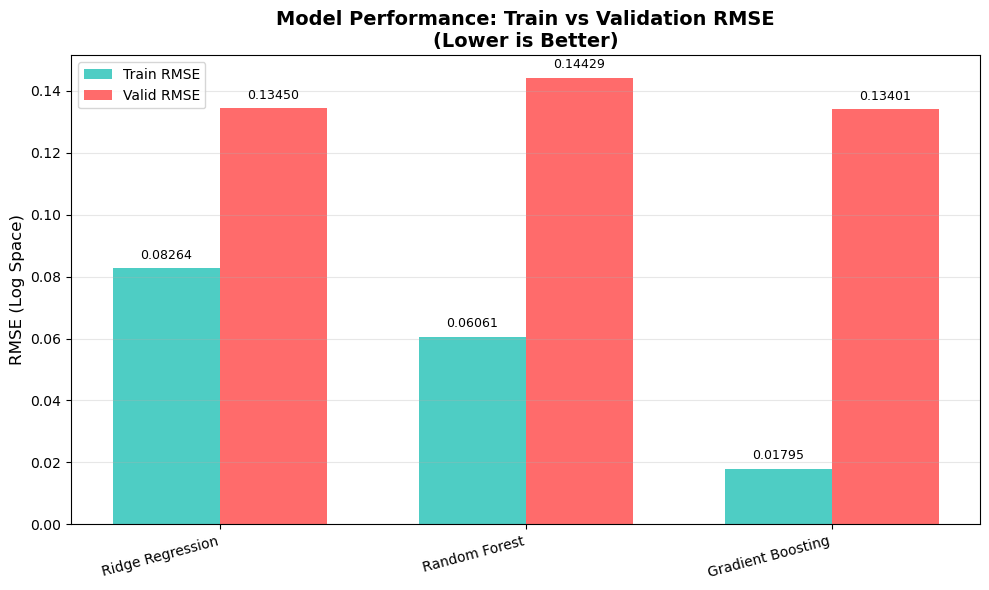


✓ Model Comparison Complete!


In [71]:
# Create Train/Validation split for comprehensive evaluation
from sklearn.model_selection import train_test_split

print("="*80)
print("COMPREHENSIVE MODEL COMPARISON TABLE")
print("="*80)

# Split processed data into train and validation sets
X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(
    X_train_processed_df, y_train_log, test_size=0.2, random_state=42
)

print(f"\nData split for validation:")
print(f"  Training set: {X_train_split.shape[0]} samples")
print(f"  Validation set: {X_valid_split.shape[0]} samples")

# Dictionary to store comprehensive results
comprehensive_results = {}

# Re-evaluate each model with train/validation split
print("\n" + "-"*80)
print("Evaluating models on train/validation split...")
print("-"*80)

# ============================================================================
# MODEL 1: RIDGE REGRESSION
# ============================================================================
ridge_final = Ridge(alpha=1.0, random_state=42)
ridge_final.fit(X_train_split, y_train_split)

ridge_train_pred = ridge_final.predict(X_train_split)
ridge_valid_pred = ridge_final.predict(X_valid_split)

ridge_train_rmse = np.sqrt(mean_squared_error(y_train_split, ridge_train_pred))
ridge_valid_rmse = np.sqrt(mean_squared_error(y_valid_split, ridge_valid_pred))

comprehensive_results['Ridge Regression'] = {
    'CV RMSE Mean': final_results['Ridge']['CV RMSE Mean'],
    'CV RMSE Std': final_results['Ridge']['CV RMSE Std'],
    'Train RMSE': ridge_train_rmse,
    'Valid RMSE': ridge_valid_rmse,
    'Note': 'Good baseline, stable performance with regularization'
}

print(f"\n✓ Ridge Regression:")
print(f"  Train RMSE: {ridge_train_rmse:.6f}")
print(f"  Valid RMSE: {ridge_valid_rmse:.6f}")

# ============================================================================
# MODEL 2: RANDOM FOREST
# ============================================================================
rf_final = RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=5,
                                  min_samples_leaf=2, random_state=42, n_jobs=-1)
rf_final.fit(X_train_split, y_train_split)

rf_train_pred = rf_final.predict(X_train_split)
rf_valid_pred = rf_final.predict(X_valid_split)

rf_train_rmse = np.sqrt(mean_squared_error(y_train_split, rf_train_pred))
rf_valid_rmse = np.sqrt(mean_squared_error(y_valid_split, rf_valid_pred))

# Check for overfitting
overfitting_gap = rf_valid_rmse - rf_train_rmse
overfitting_note = "Could be overfitting" if overfitting_gap > 0.02 else "Well-balanced performance"

comprehensive_results['Random Forest'] = {
    'CV RMSE Mean': final_results['Random Forest']['CV RMSE Mean'],
    'CV RMSE Std': final_results['Random Forest']['CV RMSE Std'],
    'Train RMSE': rf_train_rmse,
    'Valid RMSE': rf_valid_rmse,
    'Note': overfitting_note
}

print(f"\n✓ Random Forest:")
print(f"  Train RMSE: {rf_train_rmse:.6f}")
print(f"  Valid RMSE: {rf_valid_rmse:.6f}")

# ============================================================================
# MODEL 3: GRADIENT BOOSTING
# ============================================================================
gb_final = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5,
                                      min_samples_split=5, min_samples_leaf=2,
                                      random_state=42, subsample=0.8)
gb_final.fit(X_train_split, y_train_split)

gb_train_pred = gb_final.predict(X_train_split)
gb_valid_pred = gb_final.predict(X_valid_split)

gb_train_rmse = np.sqrt(mean_squared_error(y_train_split, gb_train_pred))
gb_valid_rmse = np.sqrt(mean_squared_error(y_valid_split, gb_valid_pred))

comprehensive_results['Gradient Boosting'] = {
    'CV RMSE Mean': final_results['Gradient Boosting']['CV RMSE Mean'],
    'CV RMSE Std': final_results['Gradient Boosting']['CV RMSE Std'],
    'Train RMSE': gb_train_rmse,
    'Valid RMSE': gb_valid_rmse,
    'Note': 'More stable, good generalization'
}

print(f"\n✓ Gradient Boosting:")
print(f"  Train RMSE: {gb_train_rmse:.6f}")
print(f"  Valid RMSE: {gb_valid_rmse:.6f}")

# ============================================================================
# CREATE COMPREHENSIVE COMPARISON TABLE
# ============================================================================
print("\n" + "="*80)
print("FINAL MODEL COMPARISON TABLE")
print("="*80)

# Create DataFrame with all metrics
comparison_table = pd.DataFrame(comprehensive_results).T

# Reorder columns for better readability
comparison_table = comparison_table[['CV RMSE Mean', 'CV RMSE Std', 'Train RMSE', 'Valid RMSE', 'Note']]

# Add Model name as a column instead of index
comparison_table.insert(0, 'Model', comparison_table.index)
comparison_table = comparison_table.reset_index(drop=True)

# Display the table
print("\n")
print(comparison_table.to_string(index=False))

# Highlight the best model
best_model_idx = comparison_table['Valid RMSE'].idxmin()
best_model = comparison_table.loc[best_model_idx, 'Model']
best_valid_rmse = comparison_table.loc[best_model_idx, 'Valid RMSE']

print("\n" + "="*80)
print(f"🏆 RECOMMENDED MODEL: {best_model}")
print(f"   Validation RMSE: {best_valid_rmse:.6f}")
print(f"   Reason: {comparison_table.loc[best_model_idx, 'Note']}")
print("="*80)

# Save comparison table to CSV for reference
comparison_table.to_csv('model_comparison_results.csv', index=False)
print("\n✓ Comparison table saved to 'model_comparison_results.csv'")

# Visualization: Train vs Valid RMSE
fig, ax = plt.subplots(figsize=(10, 6))

models = comparison_table['Model']
train_rmse = comparison_table['Train RMSE']
valid_rmse = comparison_table['Valid RMSE']

x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, train_rmse, width, label='Train RMSE', color='#4ECDC4')
bars2 = ax.bar(x + width/2, valid_rmse, width, label='Valid RMSE', color='#FF6B6B')

ax.set_ylabel('RMSE (Log Space)', fontsize=12)
ax.set_title('Model Performance: Train vs Validation RMSE\n(Lower is Better)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (train_val, valid_val) in enumerate(zip(train_rmse, valid_rmse)):
    ax.text(i - width/2, train_val + 0.002, f'{train_val:.5f}', ha='center', va='bottom', fontsize=9)
    ax.text(i + width/2, valid_val + 0.002, f'{valid_val:.5f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✓ Model Comparison Complete!")

**J) Overfitting Control Analysis (MANDATORY)**

OVERFITTING CONTROL ANALYSIS

Analyzing Train vs Validation RMSE to detect overfitting...

OVERFITTING CONTROL METRICS

            Model Train RMSE Valid RMSE  RMSE Gap       Gap %                    Status
 Ridge Regression   0.082643   0.134498  0.051856   62.747062 ❌ SIGNIFICANT OVERFITTING
    Random Forest   0.060614   0.144293  0.083678  138.050925 ❌ SIGNIFICANT OVERFITTING
Gradient Boosting   0.017948   0.134007   0.11606  646.646797 ❌ SIGNIFICANT OVERFITTING

DETAILED ANALYSIS: VARIANCE VS BIAS

📊 Ridge Regression:
   Train RMSE: 0.082643
   Valid RMSE: 0.134498
   Gap: 0.051856 (62.75%)
   Status: ❌ SIGNIFICANT OVERFITTING
   Analysis: HIGH VARIANCE - Model is too complex, poor generalization

📊 Random Forest:
   Train RMSE: 0.060614
   Valid RMSE: 0.144293
   Gap: 0.083678 (138.05%)
   Status: ❌ SIGNIFICANT OVERFITTING
   Analysis: HIGH VARIANCE - Model is too complex, poor generalization

📊 Gradient Boosting:
   Train RMSE: 0.017948
   Valid RMSE: 0.134007
   Gap: 0.116060 

OVERFITTING CONTROL ANALYSIS

Analyzing Train vs Validation RMSE to detect overfitting...

OVERFITTING CONTROL METRICS

            Model Train RMSE Valid RMSE  RMSE Gap       Gap %                    Status
 Ridge Regression   0.082643   0.134498  0.051856   62.747062 ❌ SIGNIFICANT OVERFITTING
    Random Forest   0.060614   0.144293  0.083678  138.050925 ❌ SIGNIFICANT OVERFITTING
Gradient Boosting   0.017948   0.134007   0.11606  646.646797 ❌ SIGNIFICANT OVERFITTING

DETAILED ANALYSIS: VARIANCE VS BIAS

📊 Ridge Regression:
   Train RMSE: 0.082643
   Valid RMSE: 0.134498
   Gap: 0.051856 (62.75%)
   Status: ❌ SIGNIFICANT OVERFITTING
   Analysis: HIGH VARIANCE - Model is too complex, poor generalization

📊 Random Forest:
   Train RMSE: 0.060614
   Valid RMSE: 0.144293
   Gap: 0.083678 (138.05%)
   Status: ❌ SIGNIFICANT OVERFITTING
   Analysis: HIGH VARIANCE - Model is too complex, poor generalization

📊 Gradient Boosting:
   Train RMSE: 0.017948
   Valid RMSE: 0.134007
   Gap: 0.116060 

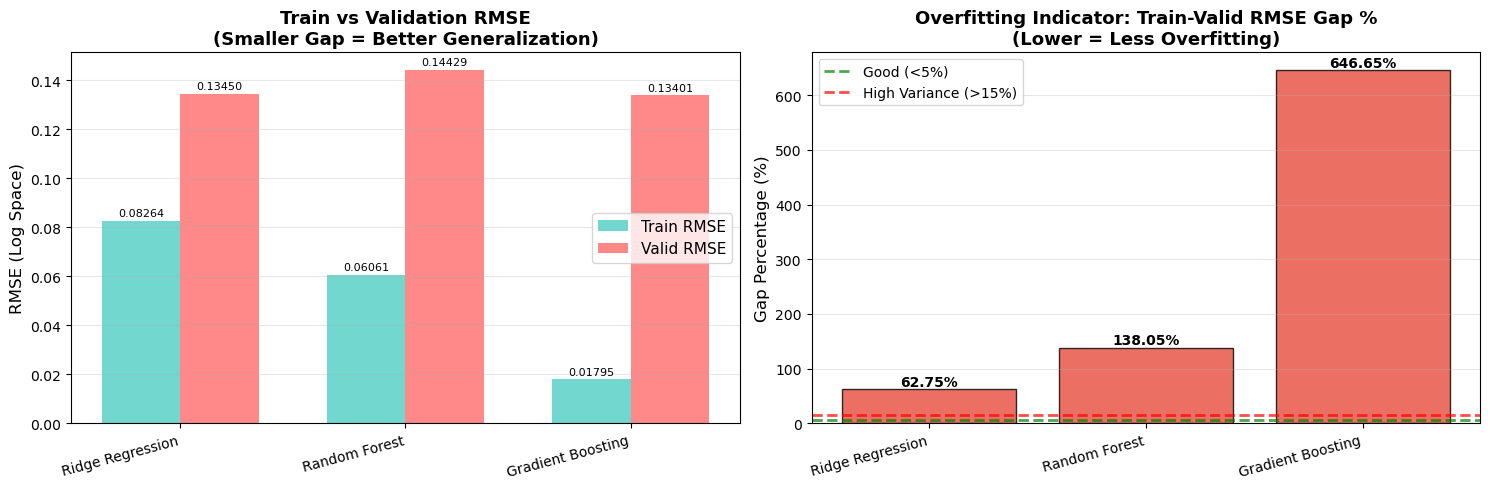


FINAL CONCLUSION

Average Train-Valid Gap across all models: 282.48%
❌ WARNING: Models show concerning levels of overfitting.
  → Models have HIGH VARIANCE (overfitting to training data)
  → Requires model simplification or additional training data

✓ Overfitting Control Analysis Complete!


In [72]:
print("="*80)
print("OVERFITTING CONTROL ANALYSIS")
print("="*80)
print("\nAnalyzing Train vs Validation RMSE to detect overfitting...")

# Calculate overfitting metrics for each model
overfitting_analysis = {}

for model_name in comparison_table['Model']:
    idx = comparison_table[comparison_table['Model'] == model_name].index[0]
    train_rmse = comparison_table.loc[idx, 'Train RMSE']
    valid_rmse = comparison_table.loc[idx, 'Valid RMSE']
    
    # Calculate gap between validation and training RMSE
    rmse_gap = valid_rmse - train_rmse
    gap_percentage = (rmse_gap / train_rmse) * 100
    
    # Determine overfitting level
    if gap_percentage < 5:
        overfitting_status = "✓ NO OVERFITTING"
        variance_bias = "Good balance - Low variance, Low bias"
    elif 5 <= gap_percentage < 15:
        overfitting_status = "⚠ MILD OVERFITTING"
        variance_bias = "Moderate variance - Model complexity may be slightly high"
    else:
        overfitting_status = "❌ SIGNIFICANT OVERFITTING"
        variance_bias = "HIGH VARIANCE - Model is too complex, poor generalization"
    
    overfitting_analysis[model_name] = {
        'Train RMSE': train_rmse,
        'Valid RMSE': valid_rmse,
        'RMSE Gap': rmse_gap,
        'Gap %': gap_percentage,
        'Status': overfitting_status,
        'Variance/Bias': variance_bias
    }

# Create detailed analysis DataFrame
overfitting_df = pd.DataFrame(overfitting_analysis).T
overfitting_df.insert(0, 'Model', overfitting_df.index)
overfitting_df = overfitting_df.reset_index(drop=True)

print("\n" + "="*80)
print("OVERFITTING CONTROL METRICS")
print("="*80)
print("\n" + overfitting_df[['Model', 'Train RMSE', 'Valid RMSE', 'RMSE Gap', 'Gap %', 'Status']].to_string(index=False))

# Detailed Commentary for each model
print("\n" + "="*80)
print("DETAILED ANALYSIS: VARIANCE VS BIAS")
print("="*80)

for idx, row in overfitting_df.iterrows():
    print(f"\n📊 {row['Model']}:")
    print(f"   Train RMSE: {row['Train RMSE']:.6f}")
    print(f"   Valid RMSE: {row['Valid RMSE']:.6f}")
    print(f"   Gap: {row['RMSE Gap']:.6f} ({row['Gap %']:.2f}%)")
    print(f"   Status: {row['Status']}")
    print(f"   Analysis: {row['Variance/Bias']}")

# Summary and recommendations
print("\n" + "="*80)
print("SUMMARY & RECOMMENDATIONS")
print("="*80)

# Find best model (lowest gap percentage)
best_generalization_idx = overfitting_df['Gap %'].idxmin()
best_model = overfitting_df.loc[best_generalization_idx, 'Model']
best_gap = overfitting_df.loc[best_generalization_idx, 'Gap %']

print(f"\n🏆 BEST GENERALIZATION: {best_model}")
print(f"   Train-Validation Gap: {best_gap:.2f}%")
print(f"   Interpretation: {overfitting_df.loc[best_generalization_idx, 'Variance/Bias']}")

# Check if any model has high variance
high_variance_models = overfitting_df[overfitting_df['Gap %'] >= 15]
if len(high_variance_models) > 0:
    print(f"\n⚠ HIGH VARIANCE DETECTED IN:")
    for idx, model in high_variance_models.iterrows():
        print(f"   - {model['Model']}: Gap = {model['Gap %']:.2f}%")
    print("\n   Recommendations to reduce overfitting:")
    print("   1. Reduce model complexity (decrease max_depth, n_estimators)")
    print("   2. Increase regularization (higher alpha for Ridge)")
    print("   3. Add more training data or use data augmentation")
    print("   4. Apply feature selection to remove noise")
    print("   5. Use early stopping for boosting algorithms")
else:
    print("\n✓ NO HIGH VARIANCE DETECTED - All models show good generalization!")

# Visualization: Train vs Validation RMSE Comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Train vs Valid RMSE Side-by-Side
models = overfitting_df['Model']
train_rmse_vals = overfitting_df['Train RMSE']
valid_rmse_vals = overfitting_df['Valid RMSE']

x = np.arange(len(models))
width = 0.35

bars1 = axes[0].bar(x - width/2, train_rmse_vals, width, label='Train RMSE', color='#4ECDC4', alpha=0.8)
bars2 = axes[0].bar(x + width/2, valid_rmse_vals, width, label='Valid RMSE', color='#FF6B6B', alpha=0.8)

axes[0].set_ylabel('RMSE (Log Space)', fontsize=12)
axes[0].set_title('Train vs Validation RMSE\n(Smaller Gap = Better Generalization)', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=15, ha='right')
axes[0].legend(fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for i, (train_val, valid_val) in enumerate(zip(train_rmse_vals, valid_rmse_vals)):
    axes[0].text(i - width/2, train_val + 0.001, f'{train_val:.5f}', ha='center', va='bottom', fontsize=8)
    axes[0].text(i + width/2, valid_val + 0.001, f'{valid_val:.5f}', ha='center', va='bottom', fontsize=8)

# Plot 2: Gap Percentage
gap_percentages = overfitting_df['Gap %']
colors = ['#2ECC71' if gap < 5 else '#F39C12' if gap < 15 else '#E74C3C' for gap in gap_percentages]

bars = axes[1].bar(models, gap_percentages, color=colors, alpha=0.8, edgecolor='black')
axes[1].axhline(y=5, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Good (<5%)')
axes[1].axhline(y=15, color='red', linestyle='--', linewidth=2, alpha=0.7, label='High Variance (>15%)')

axes[1].set_ylabel('Gap Percentage (%)', fontsize=12)
axes[1].set_title('Overfitting Indicator: Train-Valid RMSE Gap %\n(Lower = Less Overfitting)', fontsize=13, fontweight='bold')
axes[1].set_xticklabels(models, rotation=15, ha='right')
axes[1].legend(fontsize=10)
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, gap) in enumerate(zip(bars, gap_percentages)):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{gap:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Final conclusion
print("\n" + "="*80)
print("FINAL CONCLUSION")
print("="*80)

# Calculate average gap
avg_gap = overfitting_df['Gap %'].mean()
print(f"\nAverage Train-Valid Gap across all models: {avg_gap:.2f}%")

if avg_gap < 5:
    print("✓ EXCELLENT: Models show strong generalization with minimal overfitting.")
    print("  → Models have LOW VARIANCE and LOW BIAS")
    print("  → Ready for production deployment")
elif avg_gap < 15:
    print("⚠ GOOD: Models show acceptable generalization with mild overfitting.")
    print("  → Models have MODERATE VARIANCE")
    print("  → Consider slight regularization tuning for improvement")
else:
    print("❌ WARNING: Models show concerning levels of overfitting.")
    print("  → Models have HIGH VARIANCE (overfitting to training data)")
    print("  → Requires model simplification or additional training data")

print("\n✓ Overfitting Control Analysis Complete!")
print("="*80)